In [8]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from skimage.transform import rescale
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class VAE(nn.Module):
    def __init__(self, inSize=1024, latentSize=36):
        super(VAE, self).__init__()
        self.inSize = inSize
        self.latentSize = latentSize
        self.fc1 = nn.Linear(inSize, 256)
        self.fc21 = nn.Linear(256, latentSize)
        self.fc22 = nn.Linear(256, latentSize)
        self.fc3 = nn.Linear(latentSize, 256)
        self.fc4 = nn.Linear(256, inSize)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.inSize))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [3]:
size = 32

transform = transforms.Compose([transforms.Resize((size, size)),
                                transforms.ToTensor()])

train_set = MNIST(root='./',
              train=True,
             transform=transform)

batch_size = 16 

train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


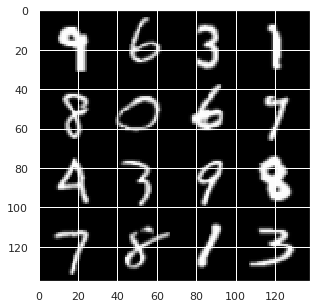

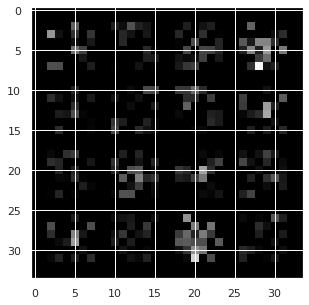

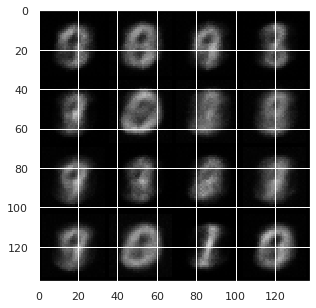

In [12]:
to_img = transforms.ToPILImage()

import matplotlib.pyplot as plt

## Original image ##
plt.figure(figsize=(5,5))
grid_img = make_grid(img, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))


## Latent representation ##
plt.figure(figsize=(5,5))
grid_img = make_grid(mu.view(batch_size,1, 6, -1).detach(), nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))

## Reconstructed image ##
plt.figure(figsize=(5,5))
grid_img = make_grid(img_recons.view(batch_size,1, 32, -1).detach(), nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))



In [30]:
vae = VAE()

##### epoch = 0 #####


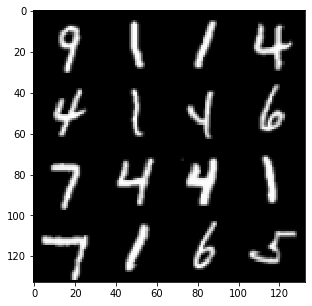

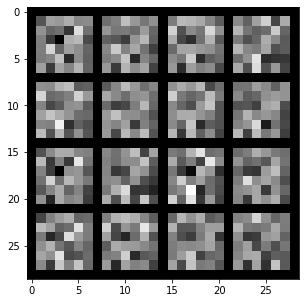

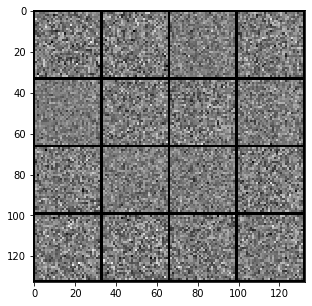


##### epoch = 10 #####


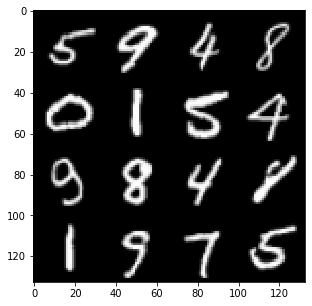

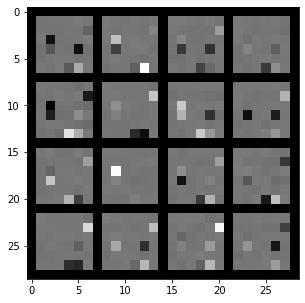

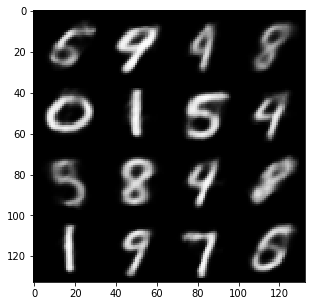

##### epoch = 20 #####


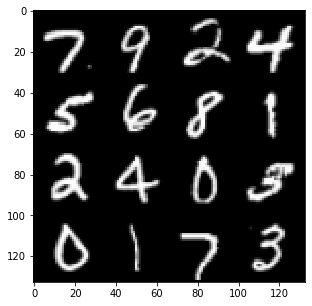

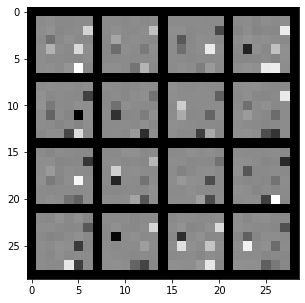

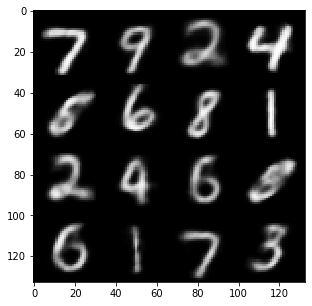

In [31]:
inSize = 32
#latentSize = 36

optimizer = optim.Adam(vae.parameters())

num_epochs = 21
display_freq = 10

t = tqdm(range(num_epochs), desc="Epoch : ", leave=True)
tt = tqdm(train_loader, desc="Batch loss : ", leave=True)


for epoch in t:
    for batch_idx, (img, labels) in enumerate(tt):
        optimizer.zero_grad()
        img_recons, mu, logvar = vae.forward(img)
        reg_loss = -1/2 * ( 1 - (mu**2).sum(-1) + logvar.sum(-1) - torch.exp(logvar).sum(-1))
        reconstruct_loss = torch.norm(img_recons - img.view(batch_size,-1), 2)
        loss = (reg_loss + reconstruct_loss).mean()
        loss.backward()
        optimizer.step()
        tt.set_description("Batch loss : %f" % loss.item())
        
        if epoch % display_freq == 0 :
            if batch_idx == 0:
                print('##### epoch = {} #####'.format(epoch))
                ## Original image ##
                plt.figure(figsize=(5,5))
                grid_img = make_grid(img, nrow=4,padding=1,  normalize=True)
                plt.imshow(grid_img.permute(1, 2, 0))
                plt.show(block=False)


                ## Latent representation ##
                plt.figure(figsize=(5,5))
                grid_img = make_grid(mu.view(batch_size,1, 6, -1).detach(), nrow=4,padding=1, normalize=True)
                plt.imshow(grid_img.permute(1, 2, 0))
                plt.show(block=False)

                ## Reconstructed image ##
                plt.figure(figsize=(5,5))
                grid_img = make_grid(img_recons.view(batch_size,1, 32, -1).detach(), nrow=4, padding=1, normalize=True)
                plt.imshow(grid_img.permute(1, 2, 0))
                plt.show(block=False)


        
        